# General imports

In [384]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import ticker

import mne

import utils.mne_microstates as microstates

from utils import plotter
from utils.utils import *

from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks

import seaborn as sns
#import seaborn.objects as so
import pandas as pd

from pycrostates.io import ChData, read_cluster

import string

from scipy.stats import ttest_rel
from statannotations.Annotator import Annotator

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import AnovaRM

### Remove future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Plotting parameters
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'lines.linewidth': 2})
plt.rcParams.update({'axes.linewidth': 1.7})
#plt.rcParams.update({'font.family': 'serif'})

### General parameter
fs = 250
n_subj = 44
subjects = np.arange(n_subj) + 1

info = load_info()

tasks = ['REST', 'S 21', 'S 51', 'S 71', 'S 22', 'S 52', 'S 72']

folder_to_save = 'results_pycrostates_250_Hz/'

factor = 0
half_window_size = 0
min_segment_length = 0
folder_statistics = folder_to_save + f'statistics_factor_{factor}_window_{half_window_size}_segment_{min_segment_length}/'

n_states = 7

### Color palettes
blue_palette = sns.color_palette("ch:s=.25,rot=-.25")
red_palette = sns.color_palette("Reds")

Reading /data/barzon/stroop/ss01_clean.fdt
Reading 0 ... 2439999  =      0.000 ...  4879.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    2.9s finished


In [56]:
### Load maps
models = read_cluster(folder_to_save+f'clustering_group_k_{n_states}.fif')

# Reorder
reorder = [1,6,0,3,4,2,5]
models.reorder_clusters(order=reorder)
# Relabel
models.rename_clusters(new_names=list(string.ascii_uppercase)[:n_states])

maps = models.cluster_centers_
# Invert polarity
polarity = np.array([1, -1, 1, 1, 1, 1, 1])
maps = maps * polarity[:,None]

In [57]:
from mne.viz import plot_topomap

def plot_maps(maps, info, figsize=None, letters=False, save=False):
    """Plot prototypical microstate maps.

    Parameters
    ----------
    maps : ndarray, shape (n_channels, n_maps)
        The prototypical microstate maps.
    info : instance of mne.io.Info
        The info structure of the dataset, containing the location of the
        sensors.
    """
    if figsize is None:
        figsize = (2 * len(maps), 2)
        
    if letters:
        names = get_names(len(maps))
        
    plt.figure(figsize=figsize)
    for i, map in enumerate(maps):
        ax = plt.subplot(1, len(maps), i + 1)
        plot_topomap(map, info, axes=ax, show=False, contours=0)
        
        if letters:
            plt.title(names[i])
        #else:
        #    plt.title('%d' % i)
            
    if save:
        plt.savefig('figures/group_maps.svg', bbox_inches='tight')
    
    plt.tight_layout()
    plt.show()

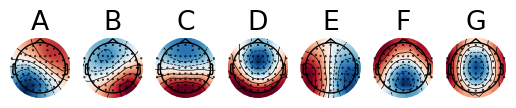

In [58]:
models.plot()
plt.show()

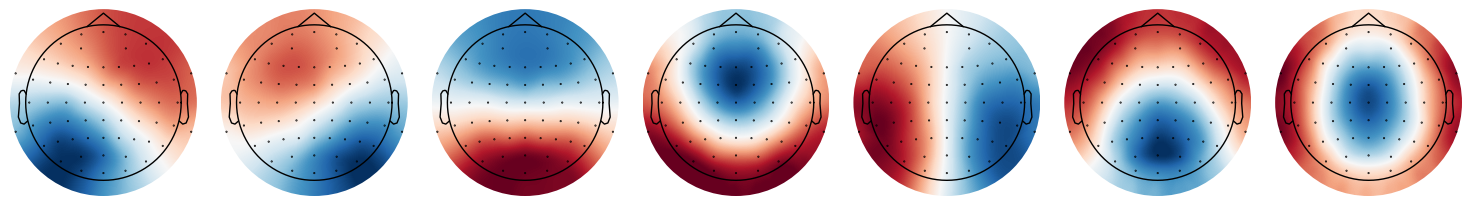

In [59]:
plot_maps(maps, info, (15,10), letters=False, save=True)

# Figure 1 - Framework

In [16]:
subj = 30
dataset = load_dataset(subj, fs=125)

Reading /home/barzon/Microstates/data_500_1_100/ss30_clean.fdt
Reading 0 ... 2545499  =      0.000 ...  5090.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 413 samples (3.304 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    1.6s finished


In [3]:
events, events_id = mne.events_from_annotations(dataset)

Used Annotations descriptions: ['RT', 'S 21', 'S 22', 'S 51', 'S 52', 'S 71', 'S 72', 'S121', 'S122', 'S151', 'S152', 'S171', 'S172']


In [4]:
data = dataset.get_data()
resting = data[:,:events[0,0]]

In [5]:
data_smooth = smoothing(data, sigma=sigma)

gfp = np.std(data, axis=0) * 1e6
gfp_smooth = np.std(data_smooth, axis=0) * 1e6

peaks, _ = find_peaks(gfp_smooth, distance=min_peak_dist)
n_peaks = len(peaks)

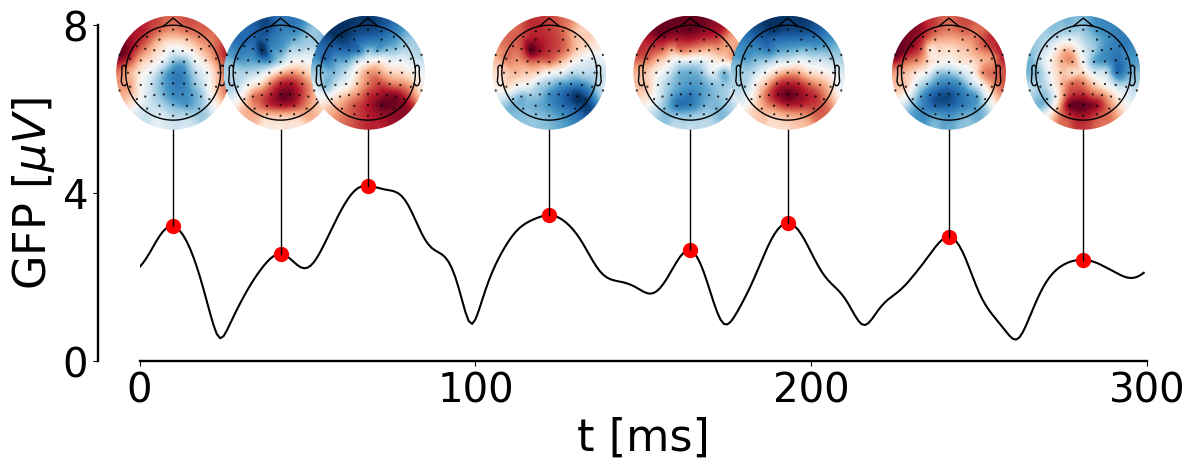

In [12]:
fact_w = 1#10
fact_h = 2.7#3.5
trange = 300
h_max = 8

size = 32

### Create figure
fig, ax = plt.subplots(figsize=(13, 4))

tup = 1095
tdw = tup+trange

times = np.arange(trange) / fs

tmp_peaks = peaks[(peaks>tup)*(peaks<tdw)]

#plt.plot(gfp[tup:tdw], label='gfp')
plt.plot(gfp_smooth[tup:tdw], label='smooth', c='k', lw=1.5)

plt.plot((tmp_peaks-tup), gfp_smooth[tmp_peaks], 'o', ms=10, c='r')

plt.xlim([0,tdw-tup])
plt.ylim([0,h_max])

plt.xlabel('t [ms]', size=size)
plt.ylabel(r'GFP [$\mu V$]', size=size)
#plt.legend()

### Add inset
bbox = ax.get_position()
scal = bbox.width / trange
for i, peak in enumerate(tmp_peaks):
    left, bottom, width, height = [bbox.x0+scal*(peak-tup)-bbox.width/fact_w/2, bbox.y0+bbox.height*0.75, bbox.width/fact_w, bbox.height/fact_h]
    ax2 = fig.add_axes([left, bottom, width, height])
    mne.viz.plot_topomap(data_smooth[:,peak], pos=dataset.info, axes=ax2,
                         show=False, contours=0, image_interp='cubic', extrapolate='head', ch_type='eeg')

    ax.plot([peak-tup, peak-tup], [gfp_smooth[peak], h_max-1], color='k', linestyle='-', linewidth=1)

### Remove spline
sns.despine(fig)
ax.spines['left'].set_position(('outward', 30))
#ax.spines['bottom'].set_position(('outward', 20))

### Fix labels
ax.set_xticks([0,100,200,300])
ax.set_yticks([0,4,8])

ax.xaxis.set_tick_params(labelsize=size-3)
ax.yaxis.set_tick_params(labelsize=size-3)

plt.savefig('figures/GFP_peaks.svg', bbox_inches='tight', transparent=True)
plt.show()

In [60]:
np.random.seed(30)
rest = [3, 7, 1, 5, 7, 2, 3]
rest = np.array(rest) / np.sum(rest)

task1 = [6, 2, 3, 5, 6, 3, 4]
task1 = np.array(task1) / np.sum(task1)

task2 = [3, 6, 1, 3, 5, 5, 2]
task2 = np.array(task2) / np.sum(task2)

In [61]:
names = ['resting', 'task1', 'taskN']
data = [rest, task1, task2]

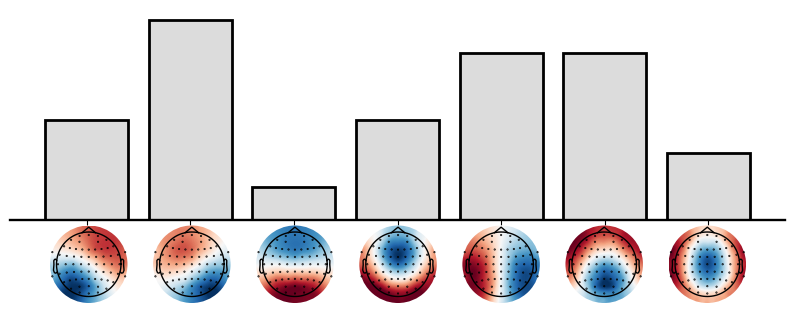

In [64]:
idx = 2

fact_w = 10
fact_h = 2
fact_l = 9.7
pad = 20

fig = plt.figure(figsize=(10,2.5))

ax = plt.subplot(1,1,1)

plt.bar(np.arange(len(maps)), data[idx], color='gainsboro', edgecolor='k', linewidth=2)

ax.tick_params(axis='x', which='major', pad=pad)
ax.axes.get_yaxis().set_visible(False)
sns.despine(fig, left=True)
plt.xticks(np.arange(len(maps)))

### Add inset
bbox = ax.get_position()
scal = bbox.width / len(maps)

for state in np.arange(len(maps)):
    left, bottom, width, height = [bbox.x0 + 0.04 + state/fact_l,
                                   bbox.y0 - 0.37,
                                   bbox.width/fact_w,
                                   bbox.height/fact_h]
    
    ax2 = fig.add_axes([left, bottom, width, height])
    mne.viz.plot_topomap(maps[state], pos=info, axes=ax2, show=False, contours=0)

plt.savefig(f'figures/distribution_{names[idx]}.svg', bbox_inches='tight', transparent=True)

plt.show()

# Figure 2 - State occurrence histograms

In [320]:
### Load stats (subj, task, state)
stats = pd.read_csv(folder_statistics+f'stats_k_{n_states}.csv')#.drop(columns=['mean_corr','gev', 'meandurs', 'occurrences'])

### Rename microstates
# Mapping from numbers to letters
#number_to_letter = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H'}

number_to_letter = {}

for tmp_idx in range(n_clusters):
    number_to_letter.update({reorder[tmp_idx]: list(string.ascii_uppercase)[tmp_idx]})
    
# Apply the mapping to the specified column
stats['microstate'] = stats['microstate'].map(number_to_letter)

### Insert condition columns
tmp_int = ['R', 'H', 'M', 'L', 'H', 'M', 'L']
tmp_cong = ['R', 'C', 'C', 'C', 'I', 'I', 'I']
tmp_comb = ['R', 'H-C', 'M-C', 'L-C', 'H-I', 'M-I', 'L-I']

col_subj = np.arange(1,n_subj+1).repeat(len(tasks)*n_states)
col_cong = np.tile(tmp_cong, n_subj).repeat(n_states)
col_int = np.tile(tmp_int, n_subj).repeat(n_states)

col_comb = np.tile(tmp_comb, n_subj).repeat(n_states)

stats.insert(2, 'ctrl', col_cong)
stats.insert(3, 'int', col_int)
stats.insert(4, 'cond', col_comb)

In [321]:
stats

,subject,task,ctrl,int,cond,microstate,mean_corr,gev,timecov,meandurs,occurrences
0,1,REST,R,R,R,C,0.870735,0.024084,0.178077,0.012327,14.446073
1,1,REST,R,R,R,A,0.778606,0.007777,0.137575,0.010645,12.924460
2,1,REST,R,R,R,F,0.786115,0.007149,0.137323,0.010173,13.498304
3,1,REST,R,R,R,D,0.808380,0.013150,0.181128,0.011835,15.304989
4,1,REST,R,R,R,E,0.684876,0.002850,0.100819,0.008844,11.399144
...,...,...,...,...,...,...,...,...,...,...,...
2151,44,S 72,I,L,L-I,F,0.841195,0.002905,0.215708,0.015505,13.911996
2152,44,S 72,I,L,L-I,D,0.818453,0.001283,0.143996,0.012126,11.875394
2153,44,S 72,I,L,L-I,E,0.697126,0.000336,0.080087,0.010043,7.974299
2154,44,S 72,I,L,L-I,G,0.768053,0.001132,0.160748,0.012412,12.951064


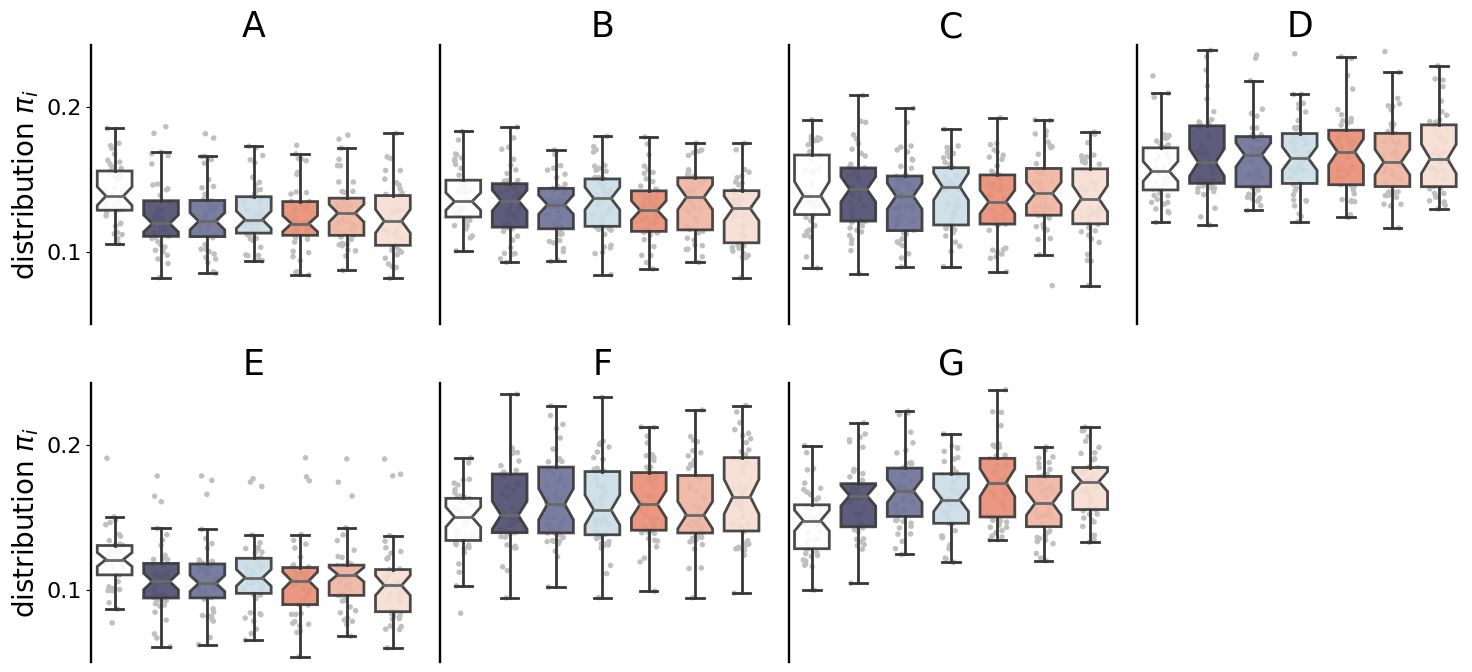

In [326]:
x = "cond"
y = "timecov"
#hue = "Cond"
order = ['R', 'L-C', 'M-C', 'H-C', 'L-I', 'M-I', 'H-I']

n_rows = 2
n_cols = 4
ylabel_size = 20
title_size = 25
figsize = (15,7)
alpha = 0.9


plt.figure(figsize=figsize)

for i, name in enumerate(get_names(n_states)):
    ax = plt.subplot(n_rows,n_cols,i+1)
    
    df_subs = stats[stats['microstate']==name]
    
    sns.boxplot(data=df_subs, x=x, y=y, ax=ax, #order=order,
                notch=True, boxprops=dict(alpha=alpha),
                width=0.75, medianprops={"color": "dimgray"}, showfliers = False,
                palette={"R": "white",
                         "H-C": blue_palette[-2], "M-C": blue_palette[-3], "L-C": blue_palette[-6],
                         "H-I": red_palette[2], "M-I": red_palette[1], "L-I": red_palette[0]},
                )
    
    sns.stripplot(data=df_subs, x=x, y=y, ax=ax, #order=order,
                  size=4, color="silver", dodge=True, jitter=0.2, zorder=0)
    ax.set_xlabel('')
    sns.despine(bottom=True)
    
    # Set y-lim
    plt.ylim(0.05,0.243)
    
    # Unset stuffs
    plt.xticks([])
    plt.legend([],[], frameon=False)
    if i%n_cols>0:
        plt.ylabel('')
        plt.yticks([])
    if i%n_cols==0:
        plt.yticks([0.1, 0.2])
        plt.ylabel(r'distribution $\pi_i$', size=ylabel_size)
    
    # Set title
    plt.title(name, size=title_size)
    
plt.tight_layout()
#plt.savefig(f'figures/figure_2.svg', bbox_inches='tight', transparent=True)
plt.show()

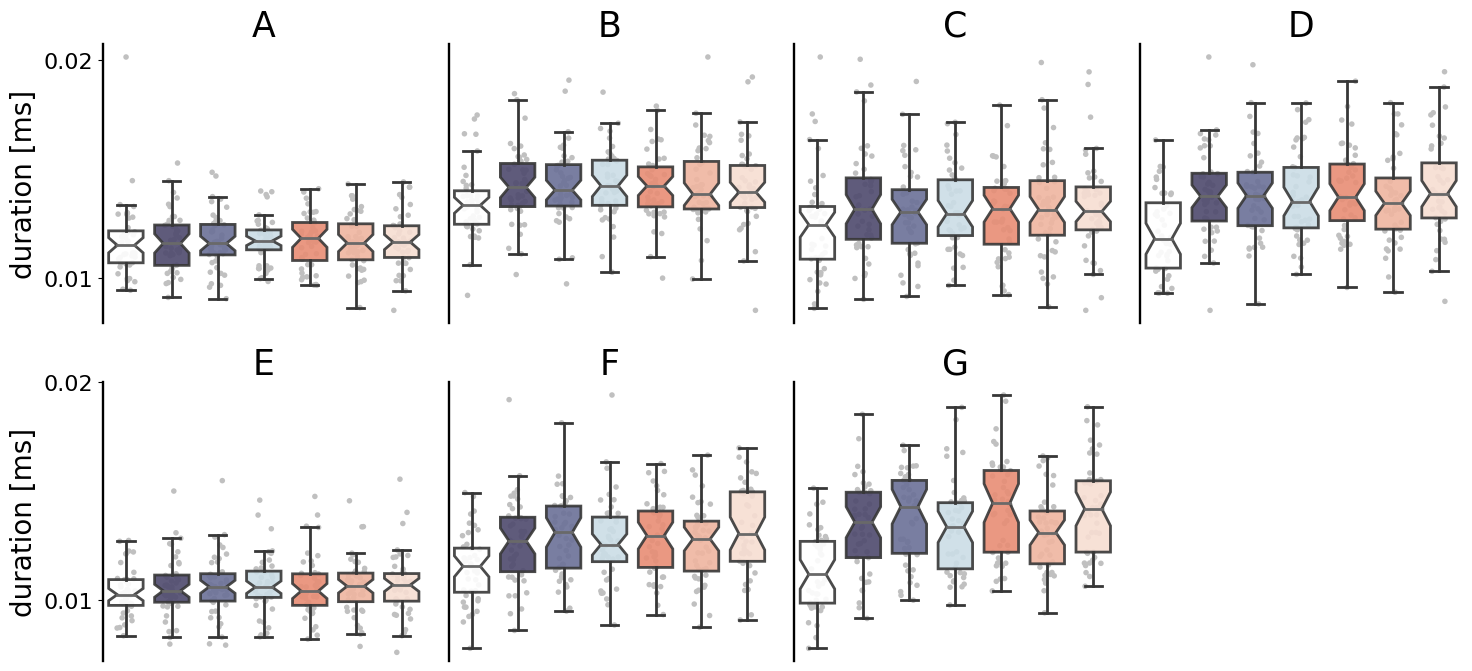

In [330]:
x = "cond"
y = "meandurs"
#hue = "Cond"
order = ['R', 'L-C', 'M-C', 'H-C', 'L-I', 'M-I', 'H-I']

n_rows = 2
n_cols = 4
ylabel_size = 20
title_size = 25
figsize = (15,7)
alpha = 0.9


plt.figure(figsize=figsize)

for i, name in enumerate(get_names(n_states)):
    ax = plt.subplot(n_rows,n_cols,i+1)
    
    df_subs = stats[stats['microstate']==name]
    
    sns.boxplot(data=df_subs, x=x, y=y, ax=ax, #order=order,
                notch=True, boxprops=dict(alpha=alpha),
                width=0.75, medianprops={"color": "dimgray"}, showfliers = False,
                palette={"R": "white",
                         "H-C": blue_palette[-2], "M-C": blue_palette[-3], "L-C": blue_palette[-6],
                         "H-I": red_palette[2], "M-I": red_palette[1], "L-I": red_palette[0]},
                )
    
    sns.stripplot(data=df_subs, x=x, y=y, ax=ax, #order=order,
                  size=4, color="silver", dodge=True, jitter=0.2, zorder=0)
    ax.set_xlabel('')
    sns.despine(bottom=True)
    
    # Set y-lim
    #plt.ylim(0.05,0.243)
    
    # Unset stuffs
    plt.xticks([])
    plt.legend([],[], frameon=False)
    if i%n_cols>0:
        plt.ylabel('')
        plt.yticks([])
    if i%n_cols==0:
        plt.yticks([0.01, 0.02])
        plt.ylabel('duration [ms]', size=ylabel_size)
    
    # Set title
    plt.title(name, size=title_size)
    
plt.tight_layout()
#plt.savefig(f'figures/figure_2.svg', bbox_inches='tight', transparent=True)
plt.show()

# Figure 3 - Transition network & transportation cost

In [111]:
names = get_names(n_states)

In [150]:
# Load co-occurrence matrices
transitions = np.load(folder_statistics+f'tmats_k_{n_clusters}.npy')
transitions = transitions.reshape(len(tasks), n_subj, n_states, n_states)

transitions.shape

(7, 44, 7, 7)

In [181]:
tmats = transitions / transitions.sum(axis=3, keepdims=1)
tmats_rest_avg = tmats.mean(axis=0)

In [173]:
# Plot log(Qij)
resting = transitions[0]
print(resting.shape)

norm = resting.sum(axis=2).sum(axis=1)

Qij = resting / norm[:,None,None]
print(Qij.shape)

(44, 7, 7)
(44, 7, 7)


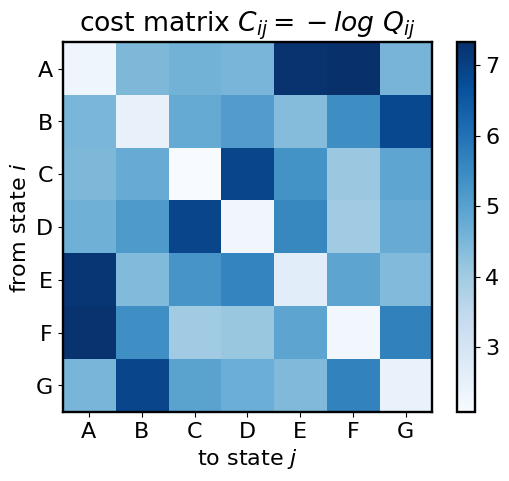

In [174]:
Cij = -np.log(Qij.mean(axis=0))

cmap = 'Blues'

plt.imshow(Cij, cmap=cmap)
cb = plt.colorbar()
#plt.xlabel('State t+1')
#plt.ylabel('State t')
plt.xlabel('to state $j$')
plt.ylabel('from state $i$')
plt.xticks(np.arange(n_states), names)
plt.yticks(np.arange(n_states), names)
plt.title(r'cost matrix $C_{ij}=-log \ Q_{ij}$')
#plt.locator_params(nbins=3)
cb.locator = ticker.MaxNLocator(nbins=6)
cb.update_ticks()

plt.savefig(f'figures/figure3_cost_matrix.svg', bbox_inches='tight', transparent=True)
plt.show()

In [157]:
# Plot network of transitions
import networkx as nx

In [175]:
# Compute deltas
deltas = np.zeros(Qij.shape)

for i in range(n_subj):
    deltas[i] = Qij[i] - Qij[i].T

In [176]:
pvals = np.zeros((n_states,n_states))

for i in range(n_states):
    for j in range(n_states):
        pvals[i,j] = ttest_rel(Qij[:,i,j], Qij[:,j,i])[1]
        
# Correction for multiple comparison
pvals *= (n_states * (n_states-1))

# Set threshold
pvals[pvals>0.05] = np.nan

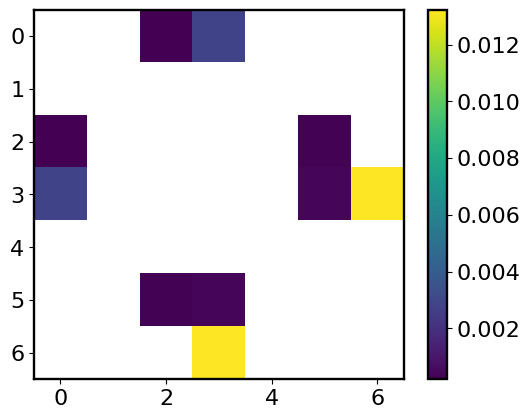

In [177]:
plt.imshow(pvals)
plt.colorbar()
plt.show()

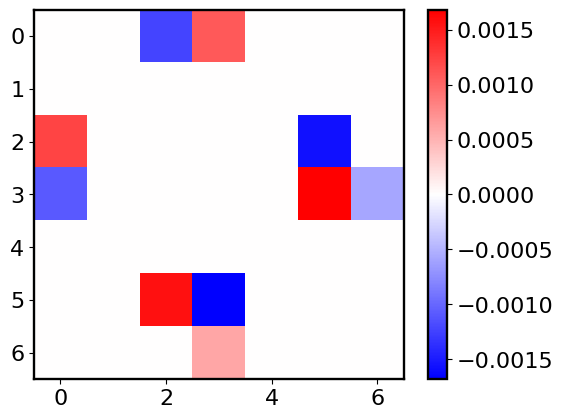

In [178]:
# Average delta
delta = deltas.mean(axis=0)

# Mask
mask = pvals>0
mask[np.isnan(mask)] = 0

# Network to plot
net_to_plot = delta * (mask>0)
net_to_plot = net_to_plot * (net_to_plot>0)

plt.imshow(delta*mask, cmap='bwr')
plt.colorbar()
plt.show()

Text(0.5, 1.0, 'p($Q_{ij}-Q_{ji})$<0.05')

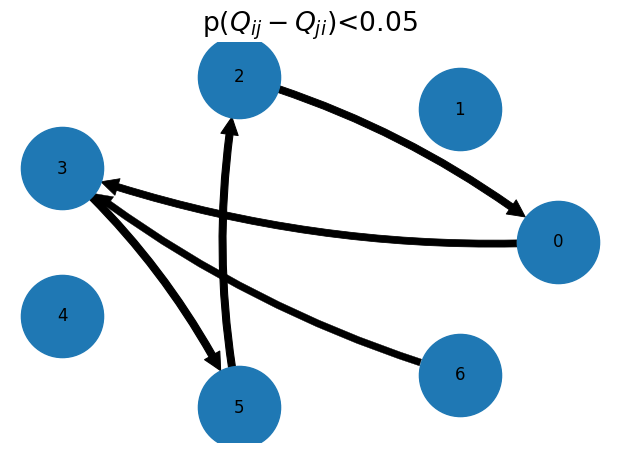

In [179]:
G = nx.from_numpy_array(net_to_plot, create_using=nx.DiGraph)

plt.figure(figsize=(6,4))
scale_w = 500

# Create fake network for reordering nodes
edges = list(G.edges(data=True))
weight = [scale_w*tmp[2]['weight'] for tmp in edges]

new_nodes = np.arange(n_states)
new_nodes = (new_nodes+5)%n_states

#fake = nx.DiGraph()
#fake.add_nodes_from(new_nodes)
#fake.add_edges_from(edges)

nx.draw(G, pos=nx.circular_layout(G), with_labels=True, node_size=3.5e3, width=weight,
        arrowstyle="simple", arrowsize=25, arrows=True,
        connectionstyle="arc3,rad=-0.1")
plt.title(r'p($Q_{ij}-Q_{ji})$<0.05')

#plt.savefig(f'figures/figure3_network.svg', bbox_inches='tight', transparent=True)

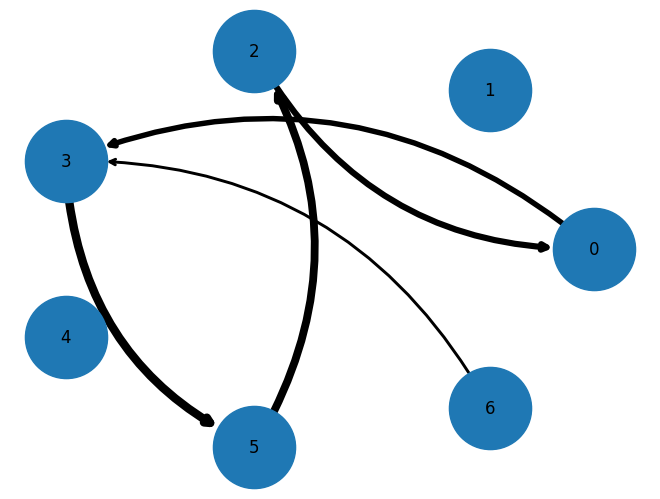

In [192]:
#plt.figure(figsize=(5,4))
scale_w = 3600

# Create fake network for reordering nodes
edges = list(G.edges(data=True))
weight = [scale_w*tmp[2]['weight'] for tmp in edges]

new_nodes = np.arange(n_states)
new_nodes = (new_nodes+5)%n_states

#fake = nx.DiGraph()
#fake.add_nodes_from(new_nodes)
#fake.add_edges_from(edges)

nx.draw(G, pos=nx.circular_layout(G), with_labels=True, node_size=3.5e3, width=weight,
        arrowstyle="->", arrowsize=10, arrows=True,
        connectionstyle="arc3,rad=0.3")

plt.savefig(f'figures/figure3_network.svg', bbox_inches='tight', transparent=True)

# Figure 4 - RT & Costs

In [386]:
plt.rcParams.update({'font.size': 20})

In [387]:
costs_rt = pd.read_csv(folder_statistics+f'cost_rt_k_{n_clusters}.csv')

col_cond = [costs_rt['ctrl'][idx]+'-'+costs_rt['cong'][idx] for idx in range(len(costs_rt.index))]

costs_rt.insert(2, 'cond', col_cond)
costs_rt

,subject,task,cond,ctrl,cong,cost,kl,rt
0,1,S 21,H-C,H,C,0.031126,0.018804,0.931947
1,1,S 22,H-I,H,I,0.057419,0.034719,0.905973
2,1,S 51,M-C,M,C,0.038370,0.022965,0.912757
3,1,S 52,M-I,M,I,0.055881,0.033690,1.023676
4,1,S 71,L-C,L,C,0.029107,0.017539,0.884311
...,...,...,...,...,...,...,...,...
259,44,S 22,H-I,H,I,0.026813,0.016363,0.933224
260,44,S 51,M-C,M,C,0.021124,0.012889,0.841730
261,44,S 52,M-I,M,I,0.039961,0.024042,0.994919
262,44,S 71,L-C,L,C,0.017591,0.010743,0.825680


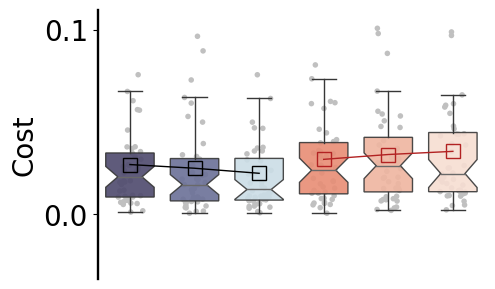

In [397]:
data_cong = costs_rt[costs_rt['cond'].isin(['H-C','M-C','L-C'])]
mean_cong = data_cong.groupby('cond').mean()
mean_cong = mean_cong['cost'].values[[0,2,1]]

data_inc = costs_rt[costs_rt['cond'].isin(['H-I','M-I','L-I'])]
mean_inc = data_inc.groupby('cond').mean()
mean_inc = mean_inc['cost'].values[[0,2,1]]

plt.figure(figsize=(5,3.5))

x = "cond"
y = "cost"
alpha = 0.9
lw = 1

order = ["H-C", "M-C", "L-C", "H-I", "M-I", "L-I"]
            
ax = sns.boxplot(data=costs_rt, x=x, y=y, notch=True, width=0.75, boxprops=dict(alpha=alpha), order=order,
                 medianprops={"color": "dimgray"}, showfliers = False, linewidth=lw,
                 palette={"H-C": blue_palette[-2], "M-C": blue_palette[-3], "L-C": blue_palette[-6],
                          "H-I": red_palette[2], "M-I": red_palette[1], "L-I": red_palette[0]},
                 #order=order
                )

sns.stripplot(data=costs_rt, x=x, y=y, ax=ax, order=order,
                  size=4, color="silver", dodge=True, jitter=0.2, zorder=0)

plt.ylabel('Cost')

# Add stat tests
'''
test_results = add_stat_annotation(ax, data=fake, x=x, y=y,
                                   box_pairs=[("H-C","L-C"), ("L-C","L-I")],
                                   test='t-test_paired', text_format='star',
                                   loc='outside', verbose=2,
                                   #order=order
                                  )
'''
'''
annotator = Annotator(ax, [("H-C","L-C"), ("L-C","L-I")], data=fake, x=x, y=y)
annotator.configure(test='t-test_paired', text_format='star', loc='outside', verbose=2)
annotator.apply_and_annotate()
'''
    
# Handle legend
#plt.legend(ncol=2, bbox_to_anchor=[-0.3, 0.2])

# Add pointplot
lw = 1
ls = '-'
marker = 's'
ms = 10
plt.plot(np.arange(3), mean_cong, lw=lw, zorder=10, ls=ls, marker=marker, ms=ms, c='k', markerfacecolor="None")
plt.plot(np.arange(3)+3, mean_inc, lw=lw, zorder=10, ls=ls, marker=marker, ms=ms, c='firebrick', markerfacecolor="None")

# Unset stuffs
plt.xticks([])
sns.despine(bottom=True)
plt.ylim(-0.035,0.111)
plt.yticks([0, 0.1])
ax.set_xlabel('')

plt.savefig(f'figures/figure4_cost.svg', bbox_inches='tight', transparent=True)

plt.show()

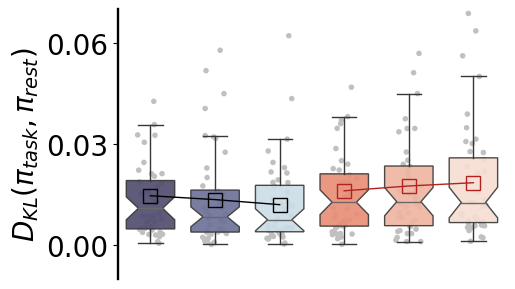

In [398]:
data_cong = costs_rt[costs_rt['cond'].isin(['H-C','M-C','L-C'])]
mean_cong = data_cong.groupby('cond').mean()
mean_cong = mean_cong['kl'].values[[0,2,1]]

data_inc = costs_rt[costs_rt['cond'].isin(['H-I','M-I','L-I'])]
mean_inc = data_inc.groupby('cond').mean()
mean_inc = mean_inc['kl'].values[[0,2,1]]

plt.figure(figsize=(5,3.5))

x = "cond"
y = "kl"
alpha = 0.9
lw = 1

order = ["H-C", "M-C", "L-C", "H-I", "M-I", "L-I"]
            
ax = sns.boxplot(data=costs_rt, x=x, y=y, notch=True, width=0.75, boxprops=dict(alpha=alpha), order=order,
                 medianprops={"color": "dimgray"}, showfliers = False, linewidth=lw,
                 palette={"H-C": blue_palette[-2], "M-C": blue_palette[-3], "L-C": blue_palette[-6],
                          "H-I": red_palette[2], "M-I": red_palette[1], "L-I": red_palette[0]},
                 #order=order
                )

sns.stripplot(data=costs_rt, x=x, y=y, ax=ax, order=order,
                  size=4, color="silver", dodge=True, jitter=0.2, zorder=0)

plt.ylabel('$D_{KL} (\pi_{task}, \pi_{rest})$')

# Add stat tests
'''
test_results = add_stat_annotation(ax, data=fake, x=x, y=y,
                                   box_pairs=[("H-C","L-C"), ("L-C","L-I")],
                                   test='t-test_paired', text_format='star',
                                   loc='outside', verbose=2,
                                   #order=order
                                  )
'''
'''
annotator = Annotator(ax, [("H-C","L-C"), ("L-C","L-I")], data=fake, x=x, y=y)
annotator.configure(test='t-test_paired', text_format='star', loc='outside', verbose=2)
annotator.apply_and_annotate()
'''
    
# Handle legend
#plt.legend(ncol=2, bbox_to_anchor=[-0.3, 0.2])

# Add pointplot
lw = 1
ls = '-'
marker = 's'
ms = 10
plt.plot(np.arange(3), mean_cong, lw=lw, zorder=10, ls=ls, marker=marker, ms=ms, c='k', markerfacecolor="None")
plt.plot(np.arange(3)+3, mean_inc, lw=lw, zorder=10, ls=ls, marker=marker, ms=ms, c='firebrick', markerfacecolor="None")

# Unset stuffs
plt.xticks([])
sns.despine(bottom=True)
plt.ylim(-0.01,0.07)
plt.yticks([0, 0.03, 0.06])
ax.set_xlabel('')

#plt.savefig(f'figures/figure4_kl.svg', bbox_inches='tight', transparent=True)
plt.savefig(f'figures/figure4_kl.png', bbox_inches='tight', dpi=300)

plt.show()

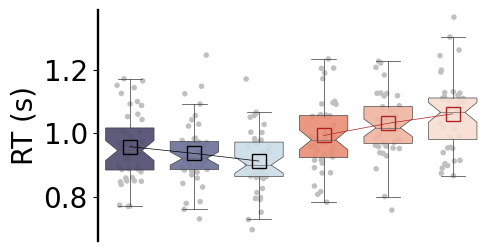

In [234]:
data_cong = costs_rt[costs_rt['cond'].isin(['H-C','M-C','L-C'])]
mean_cong = data_cong.groupby('cond').mean()
mean_cong = mean_cong['rt'].values[[0,2,1]]

data_inc = costs_rt[costs_rt['cond'].isin(['H-I','M-I','L-I'])]
mean_inc = data_inc.groupby('cond').mean()
mean_inc = mean_inc['rt'].values[[0,2,1]]

plt.figure(figsize=(5,3))

x = "cond"
y = "rt"

order = ["H-C", "M-C", "L-C", "H-I", "M-I", "L-I"]
            
ax = sns.boxplot(data=costs_rt, x=x, y=y, notch=True, width=0.75, medianprops={"color": "dimgray"}, boxprops=dict(alpha=alpha),
                 showfliers = False, linewidth=lw, order=order,
                 palette={"H-C": blue_palette[-2], "M-C": blue_palette[-3], "L-C": blue_palette[-6],
                          "H-I": red_palette[2], "M-I": red_palette[1], "L-I": red_palette[0]},
                 #order=order
                )

sns.stripplot(data=costs_rt, x=x, y=y, ax=ax, order=order,
                  size=4, color="silver", dodge=True, jitter=0.2, zorder=0)
'''
# Add stat tests
test_results = add_stat_annotation(ax, data=fake, x=x, y=y,
                                   box_pairs=[("H-C","L-C"), ("L-C","L-I")],
                                   test='t-test_paired', text_format='star',
                                   loc='outside', verbose=2,
                                   #order=order
                                  )
    
# Handle legend
#plt.legend(ncol=2, bbox_to_anchor=[-0.3, 0.2])
'''

# Add pointplot
lw = 0.5
ls = '-'
marker = 's'
ms = 10
plt.plot(np.arange(3), mean_cong, lw=lw, zorder=10, ls=ls, marker=marker, ms=ms, c='k', markerfacecolor="None")
plt.plot(np.arange(3)+3, mean_inc, lw=lw, zorder=10, ls=ls, marker=marker, ms=ms, c='firebrick', markerfacecolor="None")

# Unset stuffs
plt.xticks([])
sns.despine(bottom=True)
plt.ylim(None,1.39)
#plt.yticks([0, 0.1, 0.2])
ax.set_xlabel('')

plt.ylabel('RT (s)')

plt.savefig(f'figures/figure4_rt.svg', bbox_inches='tight', transparent=True)
#plt.savefig(f'figures/figure4_rt.png', bbox_inches='tight', dpi=300)

plt.show()

In [356]:
### Import random effects
rt_cost_ran_eff = pd.read_csv(folder_to_save+'RandomEffects.csv', delimiter=';')

cost_vs_rt = rt_cost_ran_eff.values[:,[2,3]]
rt_vs_cost = rt_cost_ran_eff.values[:,-2:]

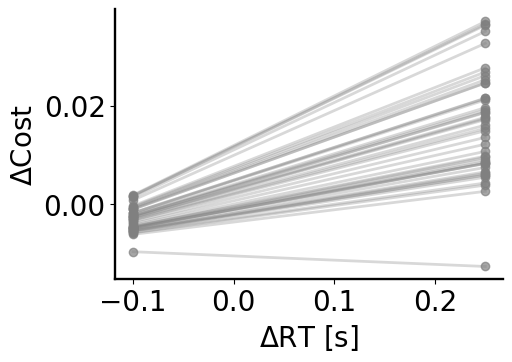

In [382]:
plt.figure(figsize=(5,3.5))
plt.plot(cost_vs_rt[0], cost_vs_rt[1:].T, c='gray', alpha=0.3)
plt.plot(cost_vs_rt[0], cost_vs_rt[1:].T, 'o', c='gray', alpha=0.7)
#plt.xlabel(r'$\Delta RT_{PC25}$')
#plt.ylabel('Random effect')
plt.ylabel(r'$\Delta$Cost')
plt.xlabel(r'$\Delta$RT [s]')
#plt.xticks([0,1],['PC25:PC50', 'PC25:PC75'])
sns.despine()
plt.savefig(f'figures/figure4_delta_rt_cost.svg', bbox_inches='tight', transparent=True)
plt.show()

# Figure A1 - Cross validation

In [315]:
validation = np.load(folder_to_save+'validation.npy')

n_clusters = np.arange(2,11)

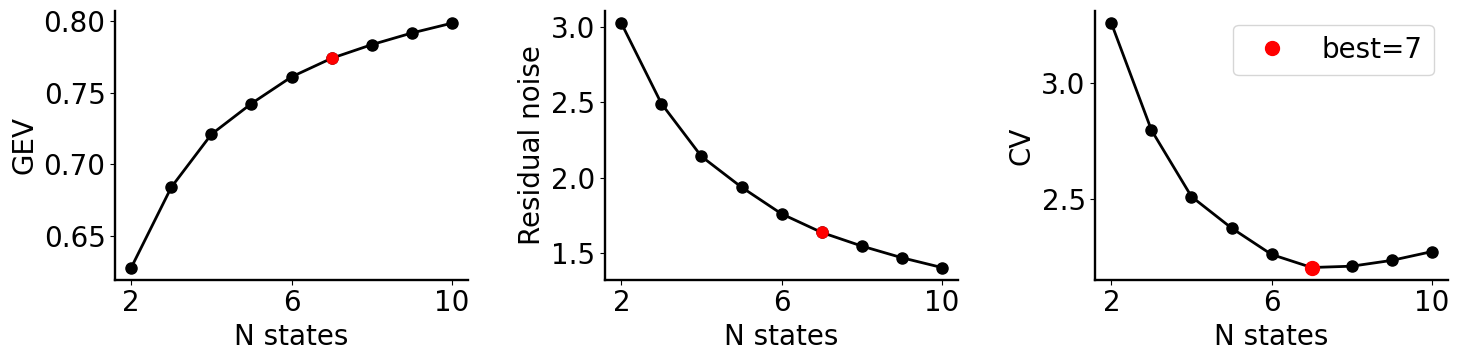

In [317]:
c = 'k'
ms = 8

gev = validation[0]
residual = validation[1]
cv = validation[2]

best = np.argmin(cv)

plt.figure(figsize=(15,4))

plt.subplot(1,3,1)

plt.plot(n_clusters, gev, '-o', c=c, ms=ms)
plt.plot(n_clusters[best], gev[best], 'o', ms=ms, c='r')
sns.despine()
plt.xticks([2, 6, 10])

plt.xlabel('N states')
plt.ylabel('GEV')

plt.subplot(1,3,2)

plt.plot(n_clusters, residual, '-o', c=c, ms=ms)
plt.plot(n_clusters[best], residual[best], 'o', ms=ms, c='r')
sns.despine()
plt.xticks([2, 6, 10])

plt.xlabel('N states')
plt.ylabel('Residual noise')

plt.subplot(1,3,3)

plt.plot(n_clusters, cv, '-o', c=c, ms=ms)
plt.plot(n_clusters[best], cv[best], 'o', ms=10, label=f'best={n_states[best]}', c='r')
sns.despine()
plt.xticks([2, 6, 10])

plt.xlabel('N states')
plt.ylabel('CV')
plt.legend()

plt.tight_layout()
plt.savefig(f'figures/figureA1.png', bbox_inches='tight', transparent=False, dpi=300)
plt.show()